In [1]:
import pandas as pd

In [2]:
import os
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.2.2'

In [3]:
#load rpy2
%load_ext rpy2.ipython

C:\Users\javte\anaconda3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [4]:
# read data
fold1 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_1.csv")
fold2 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_2.csv")
fold3 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_3.csv")
fold4 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_4.csv")
fold5 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_5.csv")

In [5]:
# load columns of full matrix
fullmatrix = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\full_matrix\matrix_logCPMrmBatch_20221207.csv",index_col=[0])
all_genes = fullmatrix.index.to_list()

In [6]:
# get intersection of all folds
intersection = set(fold1.Feature) & set(fold2.Feature)& set(fold3.Feature)& set(fold4.Feature)& set(fold5.Feature)

In [7]:
#remove decimal point from intersection -> input
intersection = list(intersection)
intersection_input = [item.split('.', 1)[0] for item in intersection]

In [8]:
#remove decimal point from custom_bg
custom_bg = [item.split('.', 1)[0] for item in all_genes]

In [9]:
#input intersection_input and custom_bg into R
%R -i intersection_input
%R -i custom_bg

In [10]:
%%R
#enrichment analysis of intersection genes
library(gprofiler2)
tmp <- 'gp__QVY5_ELVm_pOw' # goslim
go_enrichment <- gost(query = intersection_input, 
                organism = tmp,#"hsapiens", 
                ordered_query = FALSE, 
                multi_query = FALSE, significant = TRUE, exclude_iea = FALSE, 
                measure_underrepresentation = FALSE, evcodes = FALSE, 
                user_threshold = 0.2, correction_method = "fdr", 
                domain_scope = "custom", custom_bg = custom_bg, 
                source = tmp, as_short_link = FALSE)
go_enrichment <- go_enrichment$result

R[write to console]: Detected custom GMT source request

R[write to console]: Sources selection is not available for custom GMT requests. All sources in the GMT upload will be used.



In [11]:
%%R
library(dplyr)
#dataframe of results with term_name and id
diction <- select(go_enrichment, c('term_id','term_name'))
diction <- as.data.frame(diction)


R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [12]:
%R -o diction
diction.set_index('term_id',inplace=True)

In [13]:
%%R 
#filter GO enrichment for termsize<=500 and p<=0.01
filtered_go_enrichment <- go_enrichment %>% filter(term_size <= 500, p_value<=0.01)
head(filtered_go_enrichment)

    query significant      p_value term_size query_size intersection_size
1 query_1        TRUE 1.042820e-18       324       1539                92
2 query_1        TRUE 1.173737e-17       286       1539                83
3 query_1        TRUE 2.709352e-13       276       1539                73
4 query_1        TRUE 2.532059e-10       167       1539                48
5 query_1        TRUE 2.503255e-06       162       1539                39
6 query_1        TRUE 9.517614e-05       313       1539                57
   precision    recall    term_id source                         term_name
1 0.05977908 0.2839506 GO:0007059 goslim            chromosome segregation
2 0.05393112 0.2902098 GO:0140014 goslim          mitotic nuclear division
3 0.04743340 0.2644928 GO:0006260 goslim                   DNA replication
4 0.03118908 0.2874251 GO:0140013 goslim          meiotic nuclear division
5 0.02534113 0.2407407 GO:0000910 goslim                       cytokinesis
6 0.03703704 0.1821086 GO:003019

In [14]:
%%R
filtered_go_enrichment <- filtered_go_enrichment %>% top_n(100, -log10(p_value))
dim(filtered_go_enrichment)

[1] 10 14


In [15]:
%%R
library(clusterProfiler)
full_gmt <- read.gmt('goslim.gmt')

R[write to console]: 

R[write to console]: clusterProfiler v4.6.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

R[write to console]: 
Attaching package: 'clusterProfiler'


R[write to console]: The following object is masked from 'package:stats':

    filter




In [16]:
%%R
# only GO from filtered results
filtered_gmt <<- full_gmt %>% filter(term %in% filtered_go_enrichment$term_id)
length(unique(filtered_gmt$term))

[1] 10


In [17]:
%%R
#from GO enrichment results, isolate GO id and term_name columns
filtered_termnames <<- filtered_go_enrichment %>% select(term_id, term_name)
length(unique(filtered_termnames$term_id))

[1] 10


In [18]:
%%R
library(dplyr)
#runs GSEA on subtype
GSEAresult <- function(subtype){
    geneList <- read.csv(paste0("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/",subtype,".csv"), header=TRUE)
    library(clusterProfiler)
    geneList <- geneList[order(-geneList$logFC),]
    geneList$genes <- gsub("\\..*","",geneList$genes)
    newList <- geneList$logFC
    names(newList) <- geneList$genes
    res <- GSEA(newList, exponent = 1, nPerm = 1000, 
                minGSSize = 1, maxGSSize = 500, 
                pvalueCutoff = 1, 
                pAdjustMethod = "fdr", 
                TERM2GENE = filtered_gmt, 
                TERM2NAME = filtered_termnames, 
                verbose = TRUE, seed = 77)
    res <- as.data.frame(res)  
    res$Comparison <- subtype  
    return(res)
    }

In [19]:
%%R
head(filtered_gmt)

        term            gene
1 GO:0000910 ENSG00000003096
2 GO:0000910 ENSG00000004142
3 GO:0000910 ENSG00000011295
4 GO:0000910 ENSG00000011426
5 GO:0000910 ENSG00000021574
6 GO:0000910 ENSG00000036257


In [20]:
%%R
LumA <- GSEAresult('LumA')
LumB <- GSEAresult('LumB')
her2 <- GSEAresult('her2')
basal <- GSEAresult('basal')
Normal <- GSEAresult('Normal')

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...



In [21]:
%R -o LumA
%R -o LumB
%R -o her2
%R -o basal
%R -o Normal

In [22]:
all_ID = set(LumA.index).union(set(LumB.index), set(her2.index), set(basal.index), set(Normal.index))

In [23]:
all_ID = list(all_ID)
NES = pd.DataFrame(index=all_ID)
NES

Empty DataFrame
Columns: []
Index: [GO:0030198, GO:0007018, GO:0140014, GO:0006260, GO:0007568, GO:0006310, GO:0000910, GO:0003012, GO:0007059, GO:0140013]

In [24]:
dfs = [Normal, LumA, LumB, her2, basal]
names = ["Normal", "LumA", "LumB", "her2", "basal"]

In [25]:
for df, name in zip(dfs, names):
    df.rename(columns={"NES":"NES_"+name},inplace=True)

In [26]:
to_concat=[NES,Normal.iloc[:,4],LumA.iloc[:,4],LumB.iloc[:,4],her2.iloc[:,4],basal.iloc[:,4]]

In [27]:
all_NES = pd.concat(to_concat,axis=1)

In [28]:
all_NES.reset_index(inplace=True)

In [29]:
for name in reversed(list(names)):
    all_NES.sort_values(by=f"NES_{name}",ascending=False,inplace=True)

In [30]:
all_NES

index  NES_Normal  NES_LumA  NES_LumB  NES_her2  NES_basal
2  GO:0140014    2.353787  2.165961  2.643250  2.600401   2.932600
8  GO:0007059    2.301715  2.335787  2.925996  2.761432   3.001949
9  GO:0140013    2.019328  1.848172  2.329638  2.286511   2.552970
3  GO:0006260    2.001358  1.986295  2.526049  2.601741   2.704481
5  GO:0006310    1.931188  1.891084  2.402673  2.362390   2.532684
0  GO:0030198    1.911491 -1.212489 -1.485645 -1.283211  -1.139392
6  GO:0000910    1.636060  1.651847  1.995974  1.866197   2.175300
1  GO:0007018    1.100065  1.508590  1.286280  0.979008  -0.839027
4  GO:0007568   -1.081897 -1.340763 -1.241220 -1.226048  -0.974288
7  GO:0003012   -1.883260 -1.901012 -1.894920 -1.937619  -1.913902

In [31]:
all_NES.rename(columns={"index":"term_id"},inplace=True)

In [32]:
all_NES.set_index('term_id',inplace=True)

In [33]:
all_NES = all_NES.join(diction,lsuffix='term_id',rsuffix='term_name')

In [34]:
all_NES_desc = all_NES.set_index('term_name')
all_NES_desc.dropna(axis='rows',how='all',inplace=True)
all_NES_desc = all_NES_desc[['NES_Normal','NES_LumA','NES_LumB','NES_her2','NES_basal']]

<AxesSubplot:ylabel='term_name'>

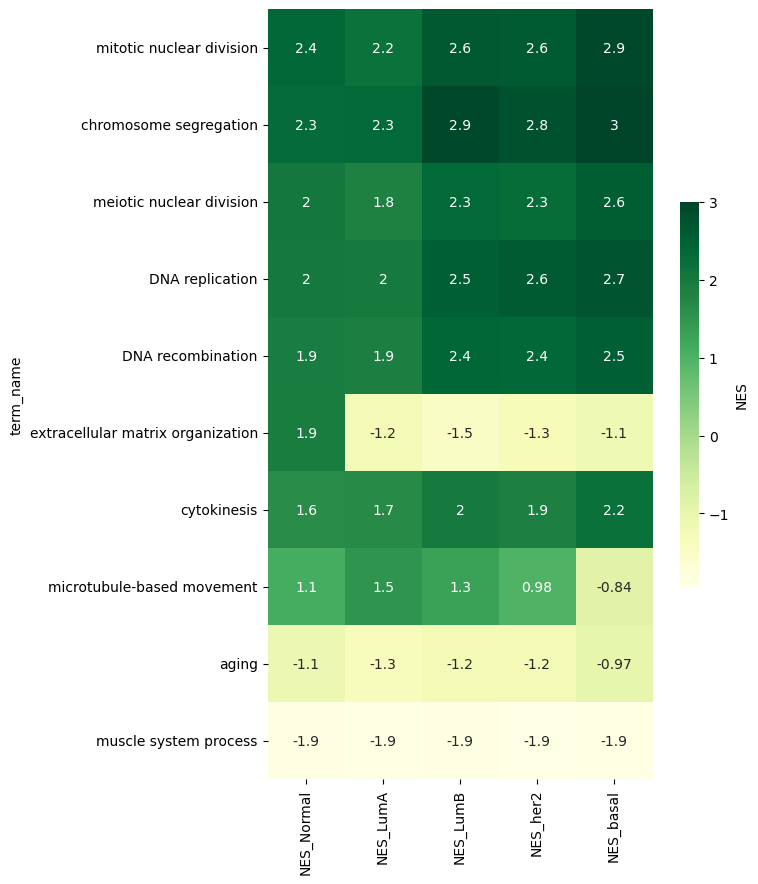

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(7,10))
    
sns.heatmap(all_NES_desc, square=True, annot = True,annot_kws={'size': 10}, cbar_kws={'shrink': 0.5, 'label': "NES"},cmap='YlGn')

In [36]:
diction

term_name
term_id                                                  
GO:0000278                             mitotic cell cycle
GO:0007059                         chromosome segregation
GO:0140014                       mitotic nuclear division
GO:0006260                                DNA replication
GO:0007010                      cytoskeleton organization
GO:0140013                       meiotic nuclear division
GO:0022414                           reproductive process
GO:0048856               anatomical structure development
GO:0000910                                    cytokinesis
GO:0030198              extracellular matrix organization
GO:0006281                                     DNA repair
GO:0050877                         nervous system process
GO:0006310                              DNA recombination
GO:0023052                                      signaling
GO:0048870                                  cell motility
GO:0007568                                          aging
GO:0030154                           cell differentiation
GO:0007018                     microtubule-based movement
GO:0003012                          muscle system process
GO:0055065                          metal ion homeostasis
GO:0007163  establishment or maintenance of cell polarity
GO:0003013                     circulatory system process
GO:0003014                           renal system process
GO:0034330                     cell junction organization
GO:0007155                                  cell adhesion
GO:0042060                                  wound healing
GO:0050886                              endocrine process

In [37]:
%%R
filtered_gmt$term <- as.character(filtered_gmt$term)

In [38]:
%R -o filtered_gmt

In [39]:
logfc_Normal = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/Normal.csv",index_col=[0])
logfc_LumA = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/LumA.csv",index_col=[0])
logfc_LumB = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/LumB.csv",index_col=[0])
logfc_her2 = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/her2.csv",index_col=[0])
logfc_basal = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/basal.csv",index_col=[0])
logdfs = [logfc_Normal,logfc_LumA,logfc_LumB,logfc_her2,logfc_basal]
for logdf in logdfs:
    logdf.rename(columns={"genes.1":"genes1"},inplace=True)
    logdf.genes1 = logdf.genes1.apply(lambda x: x.split('.', 1)[0])
    logdf.set_index('genes1',inplace=True)

In [40]:
def getGeneList(gene):
    result = filtered_gmt.query('term==@gene')
    genelist = result.gene.to_list()
    display(genelist)
    return genelist
def listQuery(genelist):
    logdfs = [logfc_Normal,logfc_LumA,logfc_LumB,logfc_her2,logfc_basal]
    for logdf in logdfs:
        logdf.query('genes1 == @genelist',inplace=True)
        logdf.sort_values(by='logFC',ascending=False,inplace=True)
    return logdfs

In [41]:
results = listQuery(getGeneList("GO:0006310"))

['ENSG00000002016',
 'ENSG00000004487',
 'ENSG00000004700',
 'ENSG00000005156',
 'ENSG00000009413',
 'ENSG00000012048',
 'ENSG00000012061',
 'ENSG00000015285',
 'ENSG00000020922',
 'ENSG00000024048',
 'ENSG00000026036',
 'ENSG00000029993',
 'ENSG00000041880',
 'ENSG00000049768',
 'ENSG00000051180',
 'ENSG00000051341',
 'ENSG00000054796',
 'ENSG00000057468',
 'ENSG00000067369',
 'ENSG00000069275',
 'ENSG00000070501',
 'ENSG00000071539',
 'ENSG00000071564',
 'ENSG00000072121',
 'ENSG00000072274',
 'ENSG00000073050',
 'ENSG00000073111',
 'ENSG00000073861',
 'ENSG00000076003',
 'ENSG00000076242',
 'ENSG00000076248',
 'ENSG00000077097',
 'ENSG00000077463',
 'ENSG00000078487',
 'ENSG00000079134',
 'ENSG00000079246',
 'ENSG00000080345',
 'ENSG00000081059',
 'ENSG00000081177',
 'ENSG00000081237',
 'ENSG00000083093',
 'ENSG00000085999',
 'ENSG00000089280',
 'ENSG00000093009',
 'ENSG00000095002',
 'ENSG00000097046',
 'ENSG00000100206',
 'ENSG00000100297',
 'ENSG00000100429',
 'ENSG00000100811',


In [42]:
to_concat=[results[0].iloc[:,0:1],results[1].logFC,results[2].logFC,results[3].logFC,results[4].logFC]
logfc_df = pd.concat(to_concat,axis=1)

In [43]:
logfc_df.columns=[['NormalLike','LumA','LumB','her2','basal']]

In [45]:
ensg_Normal = list(results[0].index)
ensg_LumA = list(results[1].index)
ensg_LumB = list(results[2].index)
ensg_her2 = list(results[3].index)
ensg_basal = list(results[4].index)
%R -i ensg_Normal
%R -i ensg_LumA
%R -i ensg_LumB
%R -i ensg_her2
%R -i ensg_basal

In [46]:
%%R
symbol_Normal <- gconvert(query = c(ensg_Normal), organism = 'hsapiens', target ='WIKIGENE')
symbol_LumA <- gconvert(query = c(ensg_LumA), organism = 'hsapiens', target ='WIKIGENE')
symbol_LumB <- gconvert(query = c(ensg_LumB), organism = 'hsapiens', target ='WIKIGENE')
symbol_her2 <- gconvert(query = c(ensg_her2), organism = 'hsapiens', target ='WIKIGENE')
symbol_basal <- gconvert(query = c(ensg_basal), organism = 'hsapiens', target ='WIKIGENE')

In [47]:
%R -o symbol_Normal
%R -o symbol_LumA
%R -o symbol_LumB
%R -o symbol_her2
%R -o symbol_basal

In [48]:
symbols = [symbol_Normal,symbol_LumA,symbol_LumB,symbol_her2,symbol_basal]
for symbol in symbols:
    symbol.drop_duplicates(subset=['name'], keep='first', inplace=True)

In [49]:
#function to write symbol
def writeSymbol(name, description):
    description_short = description.split('[', 1)[0]
    return name+': '+description_short

In [50]:
symbolDfs = [symbol_Normal, symbol_LumA, symbol_LumB, symbol_her2, symbol_basal]
for symbolDf in symbolDfs:
    symbolDf['symbol'] = symbolDf.apply(lambda x: writeSymbol(x['name'],x['description']), axis=1)

In [51]:
symbol_dict = symbolDfs[0].iloc[:,[1,7]]
symbol_dict_2 = symbol_dict.rename(columns={'input':'genes1'})
symbol_dict_index = symbol_dict_2.set_index('genes1')

In [52]:
to_add_symbols = [logfc_df,symbol_dict_index]
logfc_symbols = pd.concat(to_add_symbols,axis=1)
logfc_symbols.index.names = ['genes']
logfc_symbols.set_index('symbol',inplace=True)

In [53]:
%matplotlib inline
plt.subplots(figsize=(500,600))
plt.yticks(size=20)
sns.heatmap(logfc_symbols, square=True, annot = True,annot_kws={'size': 20}, cbar_kws={'shrink': 0.05, 'label': "log2 FC"},cmap='RdYlGn')

<AxesSubplot:ylabel='symbol'>

In [54]:
logfc_symbols

(NormalLike,)   (LumA,)  \
symbol                                                                        
FOXP3: forkhead box P3                                   2.419293  1.703279   
EXO1: exonuclease 1                                      2.196723  2.622157   
TOP2A: DNA topoisomerase II alpha                        2.184545  2.972514   
CDC45: cell division cycle 45                            2.031913  2.067625   
RECQL4: RecQ like helicase 4                             1.873818  2.094803   
...                                                           ...       ...   
ANKRD31: ankyrin repeat domain 31                       -0.981195 -0.315311   
ZSCAN4: zinc finger and SCAN domain containing 4        -1.180379 -2.047689   
HFM1: helicase for meiosis 1                            -1.231682 -2.459318   
MEI4: meiotic double-stranded break formation p...      -1.258428 -1.252625   
IHO1: interactor of HORMAD1 1                           -1.269321 -1.716191   

                                                     (LumB,)   (her2,)  \
symbol                                                                   
FOXP3: forkhead box P3                              1.985453  2.863736   
EXO1: exonuclease 1                                 4.227263  4.348948   
TOP2A: DNA topoisomerase II alpha                   4.688827  4.202680   
CDC45: cell division cycle 45                       3.599544  3.848917   
RECQL4: RecQ like helicase 4                        3.163630  2.809132   
...                                                      ...       ...   
ANKRD31: ankyrin repeat domain 31                  -0.300842 -1.436429   
ZSCAN4: zinc finger and SCAN domain containing 4   -2.773171 -2.510744   
HFM1: helicase for meiosis 1                       -2.992659 -3.138300   
MEI4: meiotic double-stranded break formation p... -1.150413 -1.404885   
IHO1: interactor of HORMAD1 1                      -2.150231 -1.737533   

                                                    (basal,)  
symbol                                                        
FOXP3: forkhead box P3                              2.590633  
EXO1: exonuclease 1                                 4.885584  
TOP2A: DNA topoisomerase II alpha                   4.474787  
CDC45: cell division cycle 45                       4.293144  
RECQL4: RecQ like helicase 4                        3.401723  
...                                                      ...  
ANKRD31: ankyrin repeat domain 31                  -1.238210  
ZSCAN4: zinc finger and SCAN domain containing 4   -2.553432  
HFM1: helicase for meiosis 1                       -1.573989  
MEI4: meiotic double-stranded break formation p... -1.689055  
IHO1: interactor of HORMAD1 1                      -2.552072  

[286 rows x 5 columns]

In [55]:
filtered_gmt.query('term=="GO:0006310"')

term             gene
890   GO:0006310  ENSG00000002016
891   GO:0006310  ENSG00000004487
892   GO:0006310  ENSG00000004700
893   GO:0006310  ENSG00000005156
894   GO:0006310  ENSG00000009413
...          ...              ...
1187  GO:0006310  ENSG00000253729
1188  GO:0006310  ENSG00000255150
1189  GO:0006310  ENSG00000258366
1190  GO:0006310  ENSG00000269964
1191  GO:0006310  ENSG00000280789

[302 rows x 2 columns]